# Showcase how to run and plot a simulation of virtual Argo floats

Here only trajectories are looked at, not measurements collected by floats.

Requirements:
- Velocity fields from Mercator forecast ([GLOBAL-ANALYSIS-FORECAST-PHY-001-024](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024))

***
Script prepared by [K Balem](http://github.com/quai20) andf [G Maze](http://github.com/gmaze) (Jun. 2020)

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [1]:
import sys
import numpy as np
import xarray as xr
import pandas as pd

sys.path.insert(0, "..") # This is while waiting for the pypi integration
import virtualargofleet as vaf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

# Set-up the velocity field

In [2]:
# Set how to find the velocity field
src = "/home/datawork-lops-oh/somovar/WP1/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024" # Datarmor
src = "/Users/gmaze/data/MERCATOR/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024" # Laptop
# src = "/home/jovyan/data" # Binder

filenames = {'U': src + "/2019*.nc",
             'V': src + "/2019*.nc"}
variables = {'U':'uo','V':'vo'}
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

In [3]:
# Ddefine the velocity field object of the VF:
# USAGE : obj = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0 or 1) 
VELfield = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0)

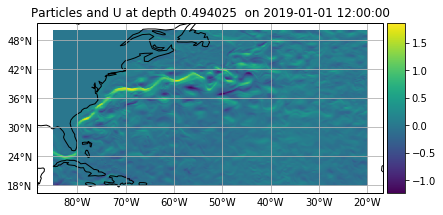

In [4]:
VELfield.plot()

# Define a deployment plan of virtual Argo floats

Choose to run one of the following plans:


## Plan A: Random in a small rectangular region

In [5]:
# Number of float we want to simulate
nfloats = 10

# Then we must define numpy array (size nfloats) for lat, lon, depth and time
lon0, lat0 = -50.00, 36.00  # Center of the box
Lx, Ly = 1., 1. # Size of the box
lon = np.random.uniform(lon0-Lx/2, lon0+Lx/2, size=nfloats)
lat = np.random.uniform(lat0-Ly/2, lat0+Ly/2, size=nfloats)
dpt = np.linspace(1.0, 1.0, nfloats) #1m depth
tim = np.full_like(lat, np.datetime64('2019-01-01'))

# DEFINE THE FLOAT OBJECT
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield)

## Plan B: Along a cruise line

In [6]:
# Number of floats we want to simulate:
nfloats = 10

# Define space/time locations of deployments:
lat = np.linspace(30, 38, nfloats)
lon = np.full_like(lat, -70)
dpt = np.linspace(1.0, 1.0, nfloats) #1m depth
tim = np.full_like(lat, np.datetime64('2019-01-01'))

# DEFINE THE FLOAT OBJECT
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield)

## Plan C: Single location, release through time

ps: this plan allows to make sure the full velocity field time series is used (floats trajectories will be different)

In [7]:
nfloats = 6
tim = pd.date_range('2019-01-01', '2019-06-01', nfloats)
lon = np.full_like(tim, -60)
lat = np.full_like(tim, 36)
dpt = np.full_like(tim, 1)
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield)

## Show deployment plan

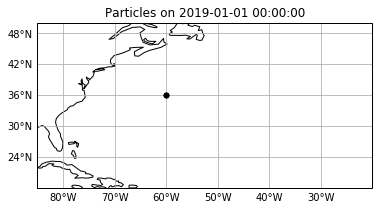

In [8]:
VFleet.plotfloat()

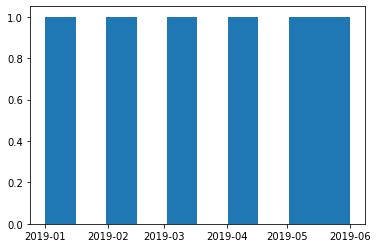

In [9]:
plt.hist(VFleet.time);

# Run the virtual fleet simulation

In [10]:
%%time
# Define where to store results
run_outputs = "out"
output_file = run_outputs + '/test_%s.nc' % pd.to_datetime('now').strftime("%Y%m%d%H%M%S")
print(output_file)

# USAGE : float_object.simulate(duration=days,dt_run=hours,dt_out=hours,output_file='my_advection_nXX.nc')
# VFleet.simulate(duration=12, dt_run=1/4, dt_out=1/6, output_file=output_file)
VFleet.simulate(duration=365, dt_run=1/2, dt_out=1, output_file=output_file)

out/test_20200629151050.nc


INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/parcels-22325/2d79d1d8ac576a5e5a8e1333f259ce2b_0.so
INFO: Temporary output files are stored in out/out-LIVBUMWW.
INFO: You can use "parcels_convert_npydir_to_netcdf out/out-LIVBUMWW" to convert these to a NetCDF file during the run.
100% |########################################################################|


CPU times: user 2min 3s, sys: 10.7 s, total: 2min 14s
Wall time: 2min 13s


# Plot the virtual fleet simulation results

In [11]:
# Load simulation results:
simu = xr.open_dataset(output_file)
print(simu)

<xarray.Dataset>
Dimensions:      (obs: 8761, traj: 6)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float32 ...
    lon          (traj, obs) float32 ...
    z            (traj, obs) float32 ...
    cycle_phase  (traj, obs) float32 ...
    cycle_age    (traj, obs) float32 ...
    drift_age    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev45+g00953f31
    parcels_mesh:           spherical


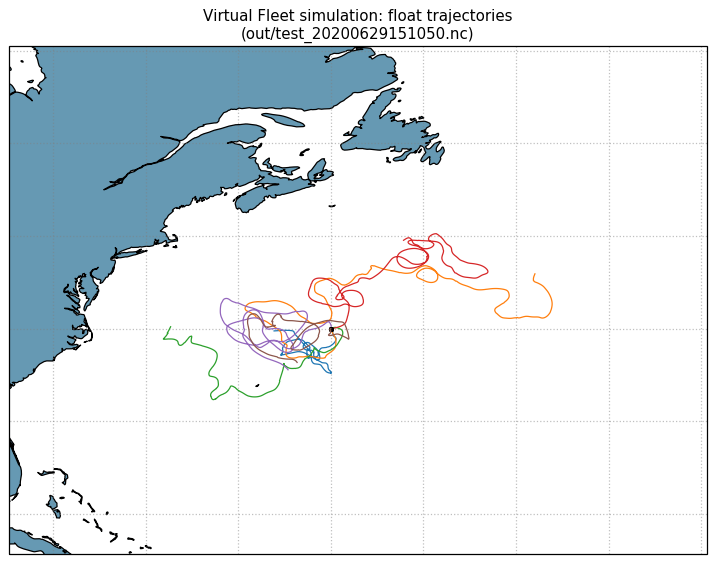

In [13]:
pr1 = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10), dpi=90)
ax3 = fig.add_subplot(1,1,1,projection=pr1)
ax3.add_feature(land_feature, edgecolor='black')
ax3.set_extent([simu.lon.min()-10, simu.lon.max()+10, simu.lat.min()-10, simu.lat.max()+10])

ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':')

# And velocity field to superimpose on plot (SLA):
if False:
    velo = xr.open_dataset(src + '/20200627_global-analysis-forecast-phy-001-024.nc')
    velo['zos'][0][:][:].plot(cmap=plt.cm.coolwarm,
                              cbar_kwargs={'orientation': 'horizontal', 'shrink':0.5, 'pad':0.1},
                              transform=pr1)

for i in simu['traj']:
    this = simu.isel(traj=i).sortby('time')
    ax3.plot(this['lon'][0], this['lat'][0],'k.', transform=pr1)
    ax3.plot(this['lon'], this['lat'], linewidth=1, transform=pr1)

plt.title("Virtual Fleet simulation: float trajectories\n(%s)" % output_file);

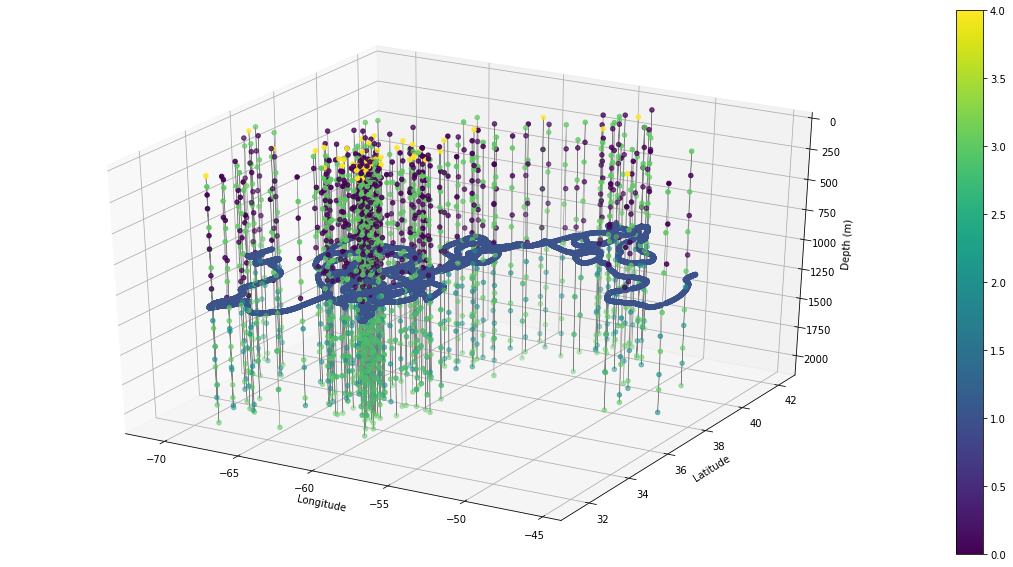

In [14]:
# trj = simu.isel(traj=0)
# trj = simu.isel(traj=nfloats-1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for it in simu['traj']:
    trj = simu.sel(traj=it)
    ax.plot(trj['lon'], trj['lat'], trj['z'], 'gray', linewidth=0.5)
    # sc = ax.scatter(trj['lon'], trj['lat'], trj['z'], c=(trj['drift_age']-trj['drift_age'][0])/3600/24)
    sc = ax.scatter(trj['lon'], trj['lat'], trj['z'], c=trj['cycle_phase'])
plt.colorbar(sc)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(trj['z']),0)
plt.show()

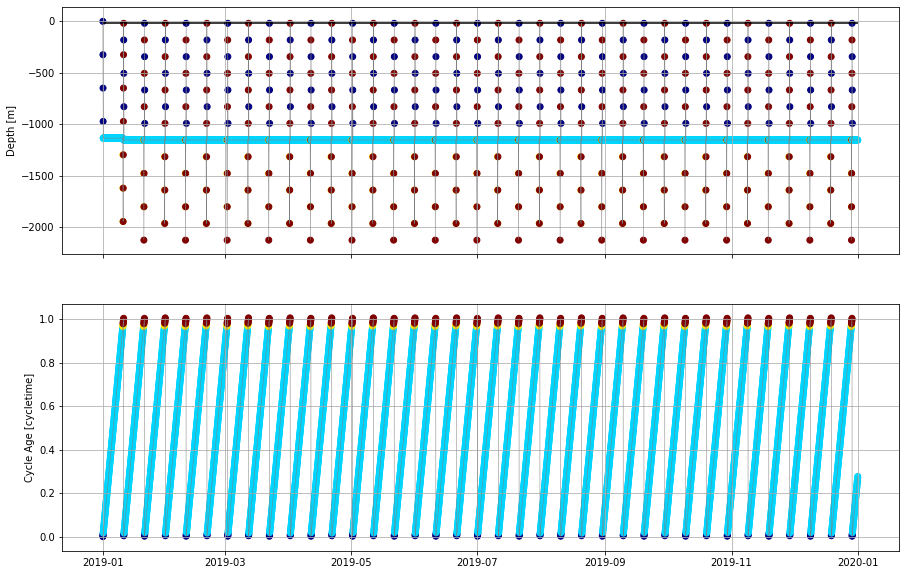

In [16]:
cycletime = 10 * 86400  # in s

trj = simu.isel(traj=0)
# trj = simu.isel(traj=nfloats-1)

dpt = trj['z']
y = trj['cycle_age']/cycletime
# y = trj['cycle_age']
# x = np.arange(0, len(y))
x = trj['time'].values

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
ax = ax.flatten()

ax[0].plot(x, -dpt, 'gray', linewidth=0.5)
sc = ax[0].scatter(x, -dpt, c=trj['cycle_phase'], marker='o', cmap=mpl.cm.get_cmap('jet', 4))
ax[0].grid()
ax[0].set_ylabel('Depth [m]')

ax[1].plot(x, y, 'gray', linewidth=0.5)
sc = ax[1].scatter(x, y, c=trj['cycle_phase'], marker='o', cmap=mpl.cm.get_cmap('jet', 4))
ax[1].set_ylabel('Cycle Age [cycletime]')
ax[1].grid()

# ax[0].set_xlim(x[0], x[400])
ax[0].hlines(-mindepth,x[~np.isnan(x)][0], x[~np.isnan(x)][-1])

In [19]:
for i in simu['traj']:
    ds = simu.sel(traj=i)
    print("Launch date:", ds['time'][0].values)

Launch date: 2019-01-01T00:00:00.000000000
Launch date: 2019-01-31T05:00:00.000000000
Launch date: 2019-03-02T10:00:00.000000000
Launch date: 2019-04-01T15:00:00.000000000
Launch date: 2019-05-01T19:12:00.000000000
Launch date: 2019-06-01T00:00:00.000000000
